In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft

In [2]:
num_frames = 100
timestep = 0.05
# timestep = 1
r_vals = np.linspace(0.0, 10.0, 501)
r_vals = r_vals[:-1]
r_vals[0] = 1e-10
M_vals = np.linspace(0, 25.0, len(r_vals)+1)
M_vals = M_vals[:-1]
M_vals[0] = 1e-10
t_vals = np.linspace(0.0, (num_frames-1)*timestep, num_frames)
t_vals[0] = 1e-10
print(f"shape of r_vals : {r_vals.shape}")
print(f"shape of M_vals : {M_vals.shape}")
print(f"shape of t_vals : {t_vals.shape}")
# print(r_vals)
# print(M_vals)
# print(t_vals)

shape of r_vals : (500,)
shape of M_vals : (500,)
shape of t_vals : (100,)


In [3]:
# s_vals = np.linspace(0.0, 2*np.pi, 101)
s_vals = np.linspace(0.0, 100, 101)
s_vals = s_vals[:-1]
s_vals[0] = 1e-10 # set s=0 to a small value
# print(s_vals)

# get the range of k values
k_vals = fft.fftfreq(r_vals.shape[0], d=r_vals[1]-r_vals[0])
# k_vals = 2 * np.pi * k_vals
# print(k_vals)
print(f"shape of k_vals : {k_vals.shape}")

shape of k_vals : (500,)


In [4]:
num_alphas = 10
alphlowlim = 0.0
alphhighlim = 0.9
num_ds = 50
dlowlim = 0.0
dhighlim = 4.9

In [5]:
alpha_vals = np.linspace(alphlowlim, alphhighlim, num_alphas)
print(alpha_vals)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value
d_vals = np.linspace(dlowlim, dhighlim, num_ds)
print(d_vals)
d_vals[0] = 1e-10 # set d=0 to a small value

# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
shape of alpha_vals : (10,)
shape of d_vals : (50,)


In [6]:
# load Z
Z = np.load("Z.npy")
print(f"shape of Z : {Z.shape}")
# print(Z)

shape of Z : (10, 50, 100, 500)


In [7]:
# normalize Z to have integral of Z over r equal to 1
Z = Z / np.sum(Z * (r_vals[1]-r_vals[0]))
# print(Z)

In [8]:
# load u_pred
u = np.loadtxt("u.txt")
print(f"shape of u : {u.shape}")
# print(u_pred)

shape of u : (100, 500)


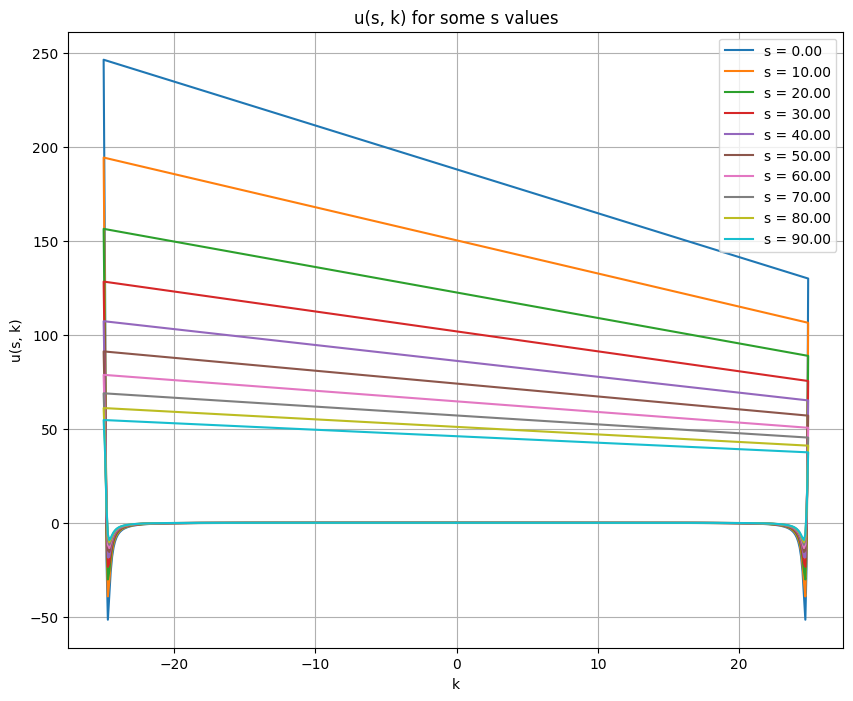

In [9]:
# plot the u_pred(s, k) for some s values
plt.figure(figsize=(10, 8))
plt.title("u(s, k) for some s values")
plt.xlabel("k")
plt.ylabel("u(s, k)")
plt.grid()
for i in range(0, s_vals.shape[0], 10):
    plt.plot(k_vals, u[i, :], label=f"s = {s_vals[i]:.2f}")

plt.legend()
plt.show()

$P_s^{i+1}(\alpha, D) = P_s^i(\alpha, D) \int \frac{u(s,k)}{u_{pred}(s,k)}Z(\alpha, D, s, k)dk$

where 

$u_{pred}(s,k) = \int \int P_s^{i}(\alpha, D) Z(\alpha, D, s, k) d\alpha dD$


In [10]:
u_pred = np.zeros(u.shape)
print(f"shape of u_pred : {u_pred.shape}")

shape of u_pred : (100, 500)


In [11]:
# initialize P_alpha_d
# P_alpha_d = np.ones((u.shape[0], num_alphas, num_ds))

# P_alpha_d = np.zeros((u.shape[0], num_alphas, num_ds))


# P_alpha_d[:, 2, 20] = 1

# initialize P_alpha_d to be a gaussian distribution with peak at (alpha, d) = (0.5, 2.5)
alpha0 = 0.5
d0 = 2.0
P_alpha_d = np.zeros((u.shape[0], num_alphas, num_ds))
for i in range(num_alphas):
    for j in range(num_ds):
        P_alpha_d[:, i, j] = np.exp(-((alpha_vals[i] - alpha0)**2 + (d_vals[j] - d0)**2) / 0.1)

# # normalize P_alpha_d
P_alpha_d = P_alpha_d / np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]

# P_alpha_d = np.ones((num_alphas, num_ds))
print(f"shape of P_alpha_d : {P_alpha_d.shape}")

P_alpha_d_old = P_alpha_d.copy()

shape of P_alpha_d : (100, 10, 50)


In [12]:
def contour_plt(P_alpha_d, i=0):
    """
    Visualise P_alpha_d as a countour plot using contourf
    """
    # plot
    # rescale the y axis to be in the range of 0 to 2
    # rescale the x axis to be in the range of 0 to 1000
    plt.figure(figsize=(4, 4))
    x = np.linspace(dlowlim, dhighlim, num_ds)
    y = np.linspace(alphlowlim, alphhighlim, num_alphas)
    plt.contourf(x, y, P_alpha_d[i], 20, cmap='RdGy')
    plt.xlabel('d')
    plt.ylabel('alpha')
    plt.colorbar()
    plt.show()

In [13]:
# visualize P_alpha_d inital
# for i in range(0, len(P_alpha_d), 5):
#     contour_plt(P_alpha_d, i)

In [14]:
def integ1(u_pred, P_alpha_d, alpha_vals, d_vals, k_vals, s_vals):
    # implement $u_{pred}(s,k) = \int \int P_s^{i}(\alpha, D) Z(\alpha, D, s, k) d\alpha dD$
    for i in range(u_pred.shape[0]):
        for j in range(u_pred.shape[1]):
            u_pred[i, j] = np.trapz(np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals, axis=1), alpha_vals, axis=0)
    # normalize u_pred for each s
    # u_pred = u_pred / (np.sum(u_pred, axis=1) + 0).reshape(-1, 1)
    
    # norm = (np.trapz(u_pred, k_vals, axis=1) + 0).reshape(-1, 1)
    # u_pred = u_pred / norm

    return u_pred

def integ2(u, u_pred, P_alpha_d, alpha_vals, d_vals, k_vals, s_vals):
    # implement $P_s^{i+1}(\alpha, D) = P_s^i(\alpha, D) \int \frac{u(s,k)}{u_{pred}(s,k)}Z(\alpha, D, s, k)dk$

    u_pred[u_pred < 1e-7] = 0

    ratio = np.divide(u, u_pred, out=np.ones_like(u), where=u_pred != 0)
    print(np.mean(ratio))
    ratio = abs(ratio)

    for i in range( P_alpha_d.shape[0]):
        for j in range(P_alpha_d.shape[1]):
            for k in range(P_alpha_d.shape[2]):
                P_alpha_d[i, j, k] *= np.trapz(ratio[i] * Z[j, k, i, :], k_vals)
                # temp = np.trapz(ratio[i] * Z[j, k, i, :], k_vals)
                # P_alpha_d[i, j, k] *= temp
                
    # normalize P_alpha_d for each s
    # P_alpha_d = P_alpha_d / (np.sum(P_alpha_d, axis=(1, 2)) + 0).reshape(-1, 1, 1)
    # norm = (np.trapz(np.trapz(P_alpha_d, d_vals, axis=2), alpha_vals, axis=1)).reshape(-1, 1, 1)
    norm = np.trapz(np.trapz(P_alpha_d, x=d_vals, axis=2), x=alpha_vals, axis=1)[:, None, None]
    P_alpha_d = P_alpha_d / norm
    return P_alpha_d

-120756.52852644766
delta : 0.0023694848380945693


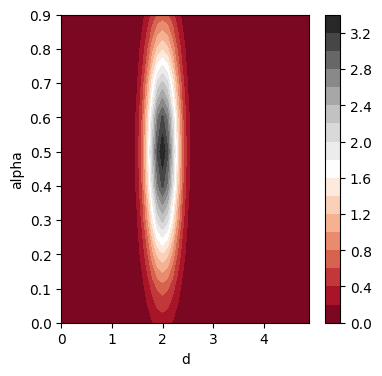

-120746.21381147059
delta : 0.0023679522943877334


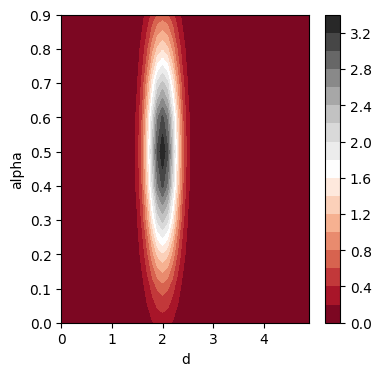

-120746.64697169139
delta : 0.0023663952399211154


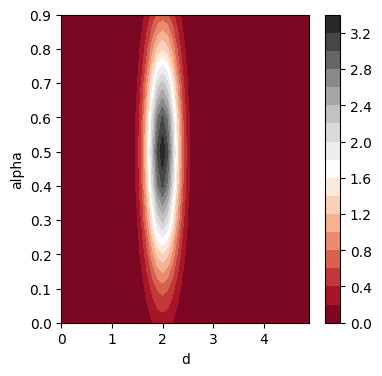

-120759.34080244809


KeyboardInterrupt: 

In [15]:
# iterate until delta is small enough
delta = 10000
num_iter = 0
# while delta > 1e-3 and num_iter < 1:
while delta > 1e-4:
    u_pred = integ1(u_pred, P_alpha_d, alpha_vals, d_vals, k_vals, s_vals)
    P_alpha_d = integ2(u, u_pred, P_alpha_d, alpha_vals, d_vals, k_vals, s_vals)
    delta = np.sum((P_alpha_d - P_alpha_d_old)**2)
    print(f"delta : {delta}")
    P_alpha_d_old = P_alpha_d.copy()
    num_iter += 1
    contour_plt(P_alpha_d, 50)
print(f"num_iter : {num_iter}")

In [ ]:
# for i in range(0, len(P_alpha_d), 5):
    # contour_plt(P_alpha_d, i)